In [1]:
from cosapp.base import System

In [2]:
class Earth(System):

    def setup(self):

        self.add_child(Gravity('grav'))
        self.add_child(Atmosphere('atmo'))
        self.add_child(Trajectory('traj'))
        self.add_child(Rocket('rocket'))

In [3]:
class Gravity(System):

    def setup(self):

        self.add_inward('x')

In [4]:
class Atmosphere(System):

    def setup(self):

        self.add_child(Density('dens'))
        self.add_child(Pressure('pres'))

In [5]:
class Trajectory(System):

    def setup(self):

        self.add_inward('x')

In [6]:
class Rocket(System):

    def setup(self):

        self.add_child(Components('comp'))
        self.add_child(Aerodynamics('aero'))
        self.add_child(Dynamics('dyn'))
        self.add_child(Kinematics('kin'))

In [7]:
class Dynamics(System):

    def setup(self):

        self.add_inward('x')

In [8]:
class Kinematics(System):

    def setup(self):

        self.add_inward('x')

In [9]:
class Aerodynamics(System):

    def setup(self):

        self.add_inward('x')

In [10]:
class Components(System):

    def setup(self):

        self.add_child(Fins('Fins'))
        self.add_child(Nose('nose'))
        self.add_child(Tube('tube'))
        self.add_child(Engine('engine'))
        self.add_child(Fuel('fuel'))
        self.add_child(Assembly('assembly'))

In [11]:
class Fins(System):

    def setup(self):

        #Geometric Parameters
        self.add_inward('s', 0.1, desc="Span of one fin", unit='m')
        self.add_inward('Cr', 0.1, desc="", unit='m')
        self.add_inward('Ct', 0.1, desc="", unit='m')
        self.add_inward('Xt', 0.1, desc="", unit='m')
        self.add_inward('delta', 0., desc="Cant angle", unit='')
        self.add_inward('tf', 0.001, desc="Fin thickness", unit='m')
        

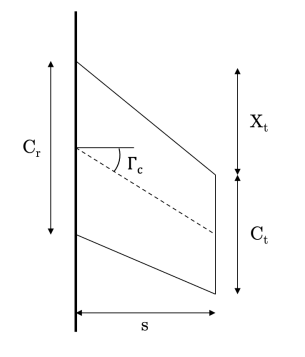

In [12]:
class Nose(System):

    def setup(self):

        self.add_inward('x')

In [13]:
class Tube(System):

    def setup(self):

        self.add_inward('x')

In [14]:
class Engine(System):

    def setup(self):

        self.add_inward('x')

In [15]:
class Fuel(System):

    def setup(self):

        self.add_inward('x')

In [16]:
class Assembly(System):

    def setup(self):

        self.add_child(COG('cog'))
        self.add_child(CPA('cpa'))
        self.add_child(Coefficients('coef'))
        self.add_child(Mass('mass'))
        self.add_child(Inertia('inertia'))

In [17]:
class COG(System):

    def setup(self):

        self.add_inward('x')

In [18]:
class CPA(System):

    def setup(self):

        self.add_inward('x')

In [19]:
class Coefficients(System):

    def setup(self):

        self.add_inward('x')

In [20]:
class Mass(System):

    def setup(self):

        self.add_inward('x')

In [21]:
class Inertia(System):

    def setup(self):

        self.add_inward('x')

In [22]:
class Density(System):

    def setup(self):

        self.add_inward('x')

In [23]:
class Pressure(System):

    def setup(self):

        self.add_inward('x')

In [24]:
earth = Earth('earth')

In [25]:
earth

earth - Earth